# Regression using gaussian processes


The material I used to build up this short tutorial can be found in http://katbailey.github.io/post/gaussian-processes-for-dummies/ (where the code were adapated from) and in this short lecture which gives a mathematical simplified (and intuitive) approach https://emtiyaz.github.io/pcml15/gp_by_carlos.pdf.

## Introduction to gaussian processes

Gaussian processes (GP) is a statistical method allowing to interpolate measurements $\boldsymbol{y}=\{y_i\}$ made at points $\boldsymbol{x}=\{x_i\}$. The basica idea is to assume that each $y_i$ is a random variable with a gaussian probability density function (PDF). Once the correlation matrix $K = \{K_{ij}\} \equiv \{\mathcal{K}(x_i,x_j)\}\equiv \mathcal{K}(\boldsymbol{x},\boldsymbol{x})$ is specified, where $\mathcal{K}(x,x')$ is called the kernel, the joint PDF (or multi-dimentional PDF) for all $\{y_i\}$ can be fully written:
$$
\text{PDF}(\boldsymbol{y}) \; = \; \mathcal{G}_{n}(\boldsymbol{x} ; \boldsymbol{\mu}, K)\; = \; \frac{1}{\sqrt{\text{det}(2\pi \,K)}} \; \text{exp} \left( \frac{1}{2} \, (\boldsymbol{x}-\boldsymbol{\mu})^{\text{T}} \, K^{-1} \, (\boldsymbol{x}-\boldsymbol{\mu}) \right)  \; \equiv \; \mathcal{N}(\boldsymbol{\mu},K)
$$


The game is then to predict the one dimensional gaussian PDF of an additional measurement to come $y^*$ at a point $x^*$, knowing all the previous measurements (training samples) and assuming how each measurement at $x$ will impact the measurement in $x'$ (encoded by the kernel).

By expliciting the two sub-spaces, one generated by $\boldsymbol{x}$ (and $\boldsymbol{y}$) and the other generated by the measurement to be predicted $\boldsymbol{x^*}$ (and $\boldsymbol{y^*}$), it becomes easy to write the joint PDF of  $(\boldsymbol{y},\boldsymbol{y^*})$:
$$
\text{PDF}\left(
  \begin{bmatrix}
    \boldsymbol{y}  \\
    \boldsymbol{y^*}
  \end{bmatrix}
  \right)
\; = \; \mathcal{N}\left(\boldsymbol{\mu},
\begin{bmatrix}
  \mathcal{K}(\boldsymbol{x},\boldsymbol{x}) & \mathcal{K}(\boldsymbol{x},\boldsymbol{x^*}) \\
  \mathcal{K}(\boldsymbol{x^*},\boldsymbol{x}) & \mathcal{K}(\boldsymbol{x^*},\boldsymbol{x^*})
\end{bmatrix}
\right)
$$

which leads to the one dimensional gaussian PDF for the new value to be predicted $\text{PDF}(\boldsymbol{y^*}) =  \mathcal{N}(\mu,\Sigma)$ with $\mu$ and $\sigma$ are perfectly detmined by the kernel, the previous measurements ($\boldsymbol{x}$ and $\boldsymbol{y}$) and the points where new measurements need to be predicted $\boldsymbol{x^*}$:

$$
\boldsymbol{\mu} \; = \; \mathcal{K}(\boldsymbol{x^*},\boldsymbol{x})^{-1} \mathcal{K}(\boldsymbol{x},\boldsymbol{x}) \:\boldsymbol{y}
$$

$$
\Sigma \; = \; \mathcal{K}(\boldsymbol{x^*},\boldsymbol{x^*}) \: - \: \mathcal{K}(\boldsymbol{x^*},\boldsymbol{x})\mathcal{K}(\boldsymbol{x},\boldsymbol{x})^{-1}\mathcal{K}(\boldsymbol{x},\boldsymbol{x^*})
$$

## Importation of the usual packages

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5

# Define global paramter to build fake data
n=100
xmin=0
xmax=4

## Definition of the kernel

The kernel specifies how two points in the feature space $x$ and $x'$ will be influence each other. There are several possibilities depending on which type or probleme need to be solve. One usual choice is the exponential squared distance:

$$
K = \{\mathcal{K}(x_i,x_j)\}_{i,j} = \text{exp}\left( {\frac{(x_i-x_j)^2}{2\ell}} \right)_{i,j} 
$$

The next piece of code define a function which return the correlation matrix and the 1D and 2D plot of the kernel function for different valeur of the hyper parameter $\ell$.

In [23]:
# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

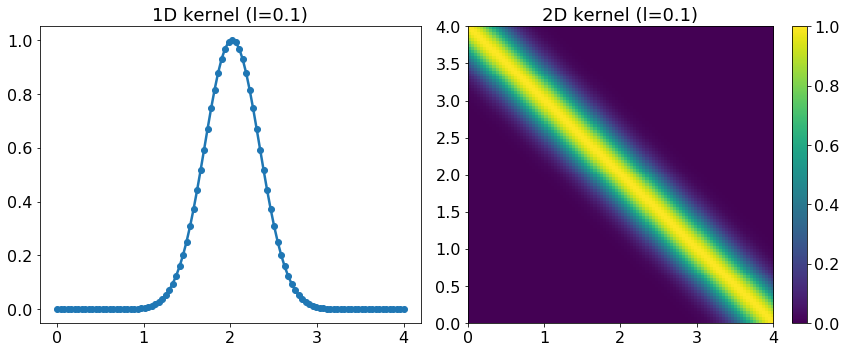

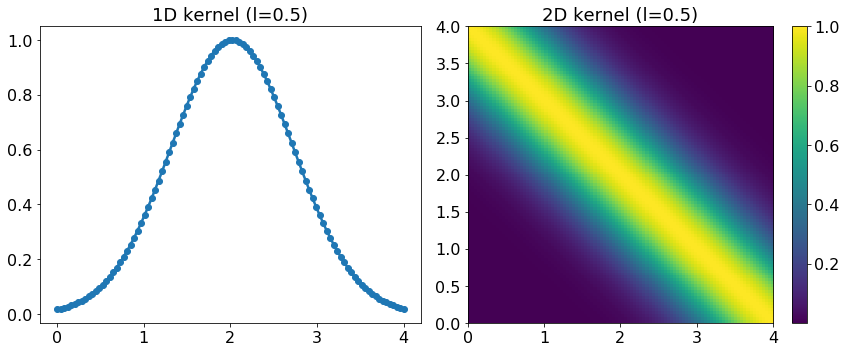

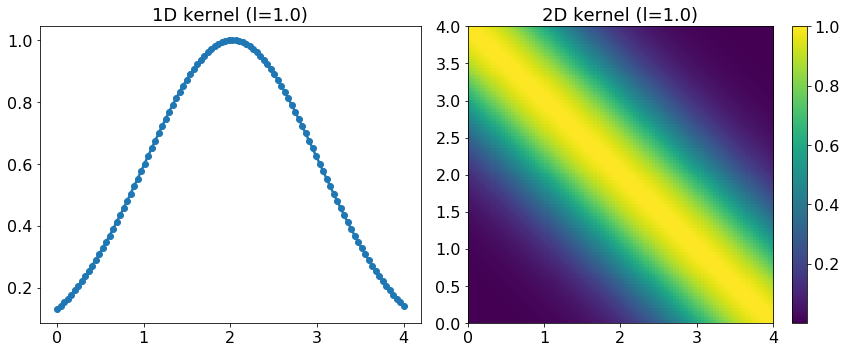

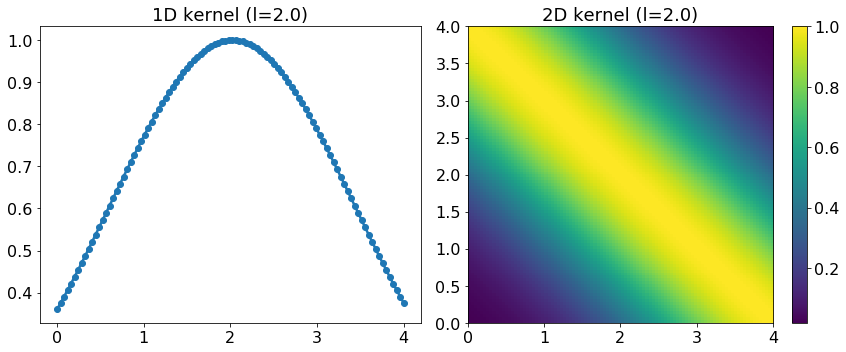

In [24]:
# Plot Kernel function
def plot_kernel_function(para):
    x=np.linspace(xmin,xmax,n).reshape(-1,1)
    myKerr = kernel(x,x,para)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title('1D kernel (l={:.1f})'.format(para))
    plt.plot( x, myKerr[:,int(n/2)] , 'o-' )
    plt.subplot(1,2,2)
    plt.title('2D kernel (l={:.1f})'.format(para))
    plt.imshow( myKerr , extent=[xmin,xmax,xmin,xmax], aspect='auto')
    plt.colorbar()
    plt.tight_layout()
    
for p in [0.1,0.5,1.0,2.0]:
    plot_kernel_function(p)

## Priors functions

What happen if the procedure is performed but without any measurements? We can investigate the typical shape of the function using randomly distributed $y_i$ (with a gaussian PDF). This is exactly what is done below: this shows the prior function that will be refined once $y_i$ values comes in.

In [37]:
# Define 5 sets of random yi
yi_random = np.random.normal(size=(n,5))

def plot_gp_priors(_xtest,param):
    
    # Compute Kernel
    K_11 = kernel(_xtest, _xtest, param)

    # Get cholesky decomposition (square root) of the covariance matrix
    L = np.linalg.cholesky( K_11 + 1e-12*np.eye(len(_xtest)) )
    
    # Define 5 priors based on gaussian-distributed {yi}
    f_prior = np.dot(L, yi_random)

    # Let's plot 3 sampled functions.
    plt.figure(figsize=(12,6))
    plt.plot(_xtest, f_prior)
    plt.axis([np.min(_xtest), np.max(_xtest), -3, 3])
    plt.title('Five samples from the GP prior for $\ell$={:.1f}'.format(param))
    plt.tight_layout()

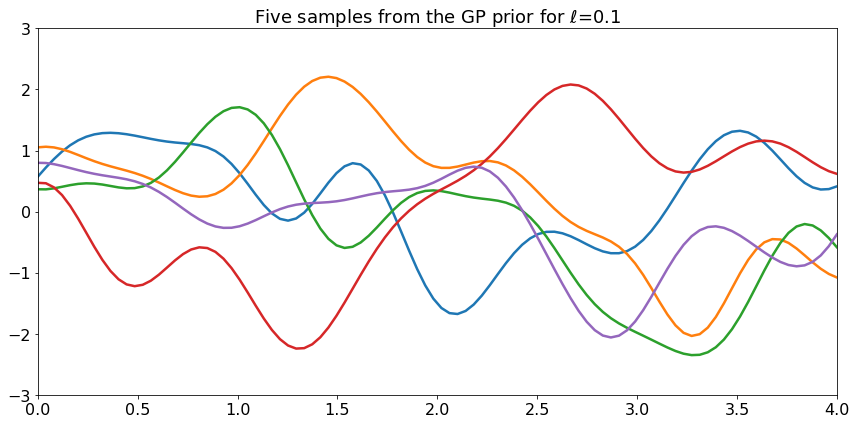

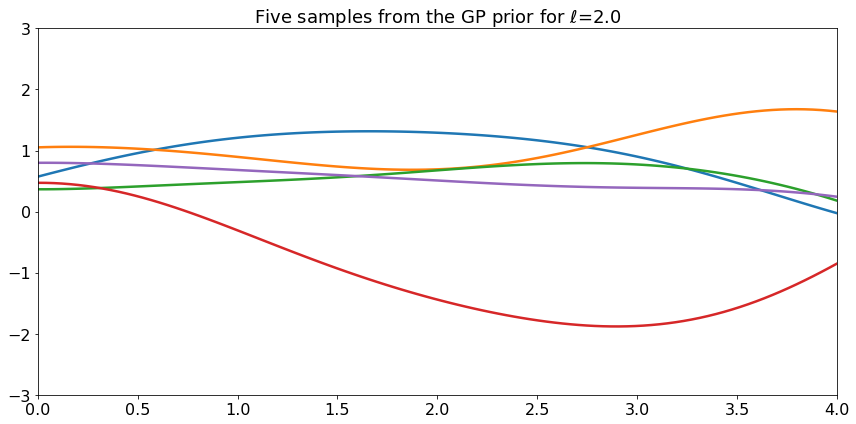

In [38]:
# Plot priors using test data
xtest = np.linspace(xmin, xmax, n).reshape(-1,1)
plot_gp_priors(xtest,0.1)
plot_gp_priors(xtest,2)

In [17]:
# Underlying function
def truth_function(x):
    return 2*x*np.sin(x)

# Noiseless training data
Ndata=5
xtrain = np.sort(0.5*(xmax-xmin)*np.random.rand(Ndata)+xmin).reshape(Ndata,1)
ytrain = truth_function(xtrain)

In [18]:
def perform_gp_prediction(_xtrain,_ytrain,_param):

    # Apply the kernel function to our training points
    K = kernel(_xtrain, _xtrain, _param)
    L = np.linalg.cholesky( K + 1e-12*np.eye(len(_xtrain)) )
    
    # Compute the mean at our test points.
    K_s = kernel(_xtrain, xtest, _param)
    Lk = np.linalg.solve(L, K_s)
    mu = np.dot(Lk.T, np.linalg.solve(L, _ytrain)).reshape((ntest,))
    
    # Compute the standard deviation so we can plot it
    K_ss = kernel(xtest, xtest, _param)
    s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
    stdv = np.sqrt(s2)

    # Get function from the posterior at our test points.
    L = np.linalg.cholesky( K_ss + 1e-12*np.eye(ntest) - np.dot(Lk.T, Lk) )
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(ntest,2)))

    # Plots things
    plt.figure(figsize=(12,6))
    plt.plot(np.linspace(xmin,xmax,500),truth_function(np.linspace(xmin,xmax,500)), label='truth' )
    for i in range(len(f_post[1])):
        plt.plot(xtest, f_post[:,i], label='posterior n{:.0f}'.format(i))
    plt.gca().fill_between(xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd", label='$\pm \, 1 \, \sigma$')
    plt.plot(xtest, mu, 'r--', lw=3, label='$\mu(x)$')
    plt.plot(_xtrain, _ytrain,'o', color='black', ms=10, zorder=10, label='data')
    plt.axis([xmin, xmax, -8, 8])
    plt.title('Gaussian Process Interpolation')
    plt.legend()
    plt.tight_layout()
    
    return

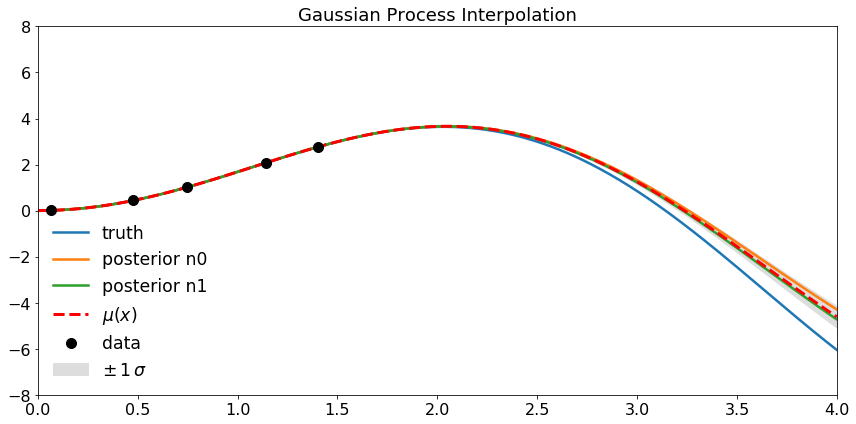

In [19]:
perform_gp_prediction(xtrain,ytrain,5)

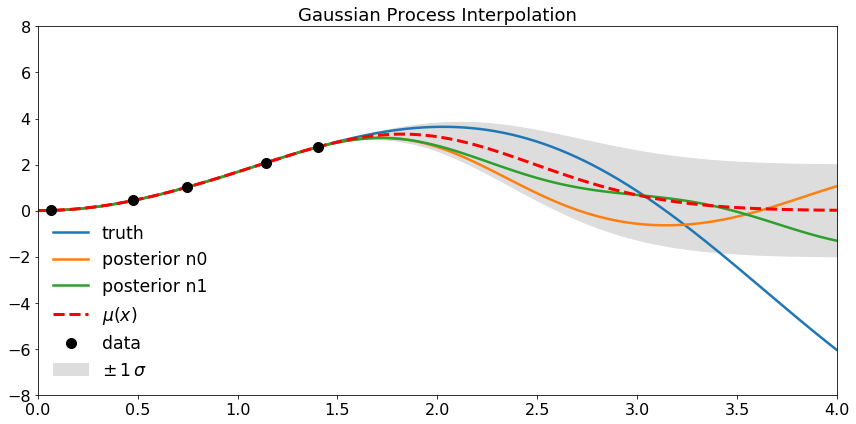

In [20]:
perform_gp_prediction(xtrain,ytrain,0.5)